# It seems we're seeing quite high leakage of real into imaginary.


In [1]:
%matplotlib notebook
from pylab import *
import numpy as np
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats
import logging
import time

In [2]:
fits='/data/craco/ban115/test_data/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits'

#fits='/data/craco/ban115/test_data/nant3/frb_d0_t0_a1_sninf_lm00/frb_d0_t0_a1_sninf_lm00.fits' # 3 antenna data
xclbin='/data/craco/ban115/builds/binary_container_1_10688715.xclbin'
#xclbin='/data/craco/ban115/builds/binary_container_01482863.xclbin'
alloc_device_only=True

In [3]:
values = craco.search_pipeline.get_parser().parse_args([])
print(values)

Namespace(boxcar_weight='sum', cand_file='candidates.txt', cell=None, device=0, dump_boxcar_hist_buf=None, dump_candidates=None, dump_fdmt_hist_buf=None, dump_mainbufs=None, dump_uvdata=None, fdmt_scale=1.0, fft_scale=10.0, fft_shift1=0, fft_shift2=7, input_scale=1.0, max_ndm=1024, nblocks=1, nbox=8, ncin=32, ndm=2, ndout=186, npix=256, nt=256, nuvmax=8192, nuvwide=8, os='2.1,2.1', run_fdmt=True, run_image=True, show=False, show_candidate_grid=None, threshold=10.0, uv='frb_d0_lm0_nt16_nant24.fits', verbose=False, wait=False, xclbin='binary_container_1.xclbin.golden')


In [4]:
device = pyxrt.device(1)
xbin = pyxrt.xclbin(xclbin)
uuid = device.load_xclbin(xbin)

parsing values --ndm 2 --max-nbl 3


<IPython.core.display.Javascript object>


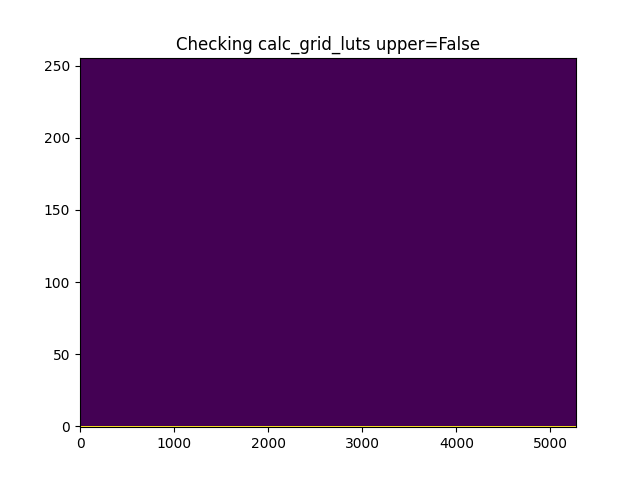

Upper registers [(37, 6), (37, 7), (38, 7), (38, 8), (39, 8), (39, 9), (40, 9), (40, 10), (40, 11), (41, 11), (102, 11), (41, 12), (42, 12), (102, 12), (42, 13), (43, 13), (102, 13), (43, 14), (102, 14), (103, 14), (18, 15), (43, 15), (44, 15), (103, 15), (18, 16), (19, 16), (44, 16), (45, 16), (103, 16), (19, 17), (20, 17), (45, 17)]
Lower registers [(26, 47), (26, 48), (27, 48), (27, 49), (28, 49), (28, 50), (29, 50), (30, 51), (31, 51), (31, 52), (32, 52), (32, 53), (33, 53), (33, 54), (34, 54), (35, 54), (35, 55), (36, 55), (53, 55), (54, 55), (6, 56), (36, 56), (37, 56), (54, 56), (55, 56), (7, 57), (8, 57), (37, 57), (38, 57), (55, 57), (56, 57), (8, 58)]


In [5]:
f = uvfits.open(fits)
plan = PipelinePlan(f, "--ndm 2 --max-nbl 3")

In [6]:
p = craco.search_pipeline.Pipeline(device, xbin, plan, alloc_device_only)

Kernel krnl_ddgrid_reader_4cu:krnl_ddgrid_reader_4cu_1 has groups
GID=0=32
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=15
Kernel krnl_grid_4cu:krnl_grid_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=6
Kernel krnl_grid_4cu:krnl_grid_4cu_2 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=7
Kernel krnl_grid_4cu:krnl_grid_4cu_3 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=20
Kernel krnl_grid_4cu:krnl_grid_4cu_4 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=-1
GID=4=-1
GID=5=21
Kernel fft2d:fft2d_1 has groups
Kernel fft2d:fft2d_2 has groups
Kernel fft2d:fft2d_3 has groups
Kernel fft2d:fft2d_4 has groups
Kernel krnl_boxc_4cu:krnl_boxc_4cu_1 has groups
GID=0=-1
GID=1=-1
GID=2=-1
GID=3=54
GID=4=54
GID=5=4
Kernel fdmt_tunable_c32:fdmt_tunable_c32_1 has groups
GID=0=52
GID=1=32
GID=2=53
GID=3=53
GID=4=14
Allocated 360428 bytes flags=flags.normal groupid=6 address=0x60000000
Allocated 360428 bytes flags=flags.normal groupid=7 address=0x70000000
Allo

In [7]:
all_cands = []
dm = 0
t0 = 0
p.clear_buffers(values)
# dmamp = 32 gives SNR=14.2
dmamp = 32
print('t0', t0)

# put in a value for a single time and DM
for b in p.all_mainbufs:
    b.nparr[:] = 0
    b.nparr[:,dm,0,t0,:,0] = dmamp
    b.copy_to_device()

values.run_fdmt = False
values.run_image = True
values.threshold = 5
p.run(0, values).wait()
cands = p.get_candidates().copy()
all_cands.append(cands)
#c0 = cands[0]
#print(c0)
#assert c0['upix'] == 128
#assert c0['vpix'] == 128
#assert c0['boxc_width'] == 0
#assert c0['time'] == t0
#assert c0['dm'] == 0
print_candidates(cands, 256, 0)
centrepix = cands[cands['loc_2dfft'] == 0] # 128, 128
print_candidates(centrepix, 256,0)

t0 0
# SNR	upix	vpix	boxc_width	time	dm	iblk

83.4	128	128	0		0	0	0
7.2	129	129	0		0	0	0
35.0	127	129	0		0	0	0
7.8	138	130	0		0	0	0
5.3	122	130	0		0	0	0
7.6	128	131	0		0	0	0
5.1	115	131	0		0	0	0
5.1	134	132	0		0	0	0
8.1	124	132	0		0	0	0
7.9	133	133	0		0	0	0
8.2	125	133	0		0	0	0
6.6	134	134	0		0	0	0
5.1	126	134	0		0	0	0
7.0	135	135	0		0	0	0
5.4	127	135	0		0	0	0
6.3	136	136	0		0	0	0
6.8	110	136	0		0	0	0
8.2	114	136	0		0	0	0
6.0	135	137	0		0	0	0
5.5	179	137	0		0	0	0
5.3	109	137	0		0	0	0
5.6	113	137	0		0	0	0
12.0	122	138	0		0	0	0
5.5	91	139	0		0	0	0
11.0	121	139	0		0	0	0
7.9	120	140	0		0	0	0
5.2	111	141	0		0	0	0
7.4	123	141	0		0	0	0
5.1	71	145	0		0	0	0
6.2	116	148	0		0	0	0
8.3	115	149	0		0	0	0
5.2	114	150	0		0	0	0
6.0	97	155	0		0	0	0
6.2	115	155	0		0	0	0
5.9	96	156	0		0	0	0
5.6	95	157	0		0	0	0
5.8	111	161	0		0	0	0
5.8	145	95	0		0	0	0
5.6	161	99	0		0	0	0
5.9	160	100	0		0	0	0
6.2	141	101	0		0	0	0
6.0	159	101	0		0	0	0
5.2	142	106	0		0	0	0
8.3	141	107	0		0	0	0
6.2	140	108	0		0	0	0
5.1	185	111	

# In pixels that aren't 128, 128 we're seeing signal at boxcar=0, time=1. I thought all the data was loaded into boxcar=0, time=0 and that fourier plan should be essentially empty

So, we should run it through the gridding pipeline to see what it looooks-like.


In [8]:
import craco_pybind11
import craco_pybind11.ddgrid_reader
import craco_pybind11.grid
nchunk_time = plan.nchunk_time
nparallel_uvin, nparallel_uvout, h_nparallel_uvout, lut = get_grid_lut_from_plan(plan)
nuvrest = nparallel_uvin*2//8
NUVWIDE = 8
OUTPUT_NT = 2
OUTPUT_NUV = 2
ncu = 4
ndm = plan.nd
tblk = 0
do_load_lut = 1

In [9]:
#outputs = np.zeros((ncu, ndm, nchunk_time, nuvrest, 4, 2, dtype=np.int16) for n in range(ncu)]
outputs = np.zeros((ncu, ndm, nchunk_time, nuvrest, NUVWIDE//OUTPUT_NUV, OUTPUT_NT, OUTPUT_NUV, 2), dtype=np.int16)

In [10]:
mainbuf = p.copy_mainbuf()

In [11]:
craco_pybind11.ddgrid_reader.krnl_ddgrid_reader_4cu(mainbuf, 
                                     ndm, 
                                     tblk,
                                     nchunk_time, 
                                     nuvrest, 
                                     plan.ddreader_lut, 
                                     do_load_lut, 
                                     outputs[0], 
                                     outputs[1], 
                                     outputs[2], 
                                     outputs[3])

In [12]:
print(outputs.shape)
print(mainbuf.shape)


(4, 2, 32, 659, 4, 2, 2, 2)
(664, 186, 11, 256, 8, 2)


In [13]:
reordered = np.transpose(outputs, [1, 2,0,5, 3,4,6, 7])
#assert reordered.shape == (ndm, nchunk_time, ncu, OUTPUT_NT, nuvrest, NUVWIDE, 2)
reordered = reordered.reshape(ndm, ncu*nchunk_time*OUTPUT_NT, nuvrest*NUVWIDE, 2)

In [14]:
print(reordered.shape)
imshow(reordered[0,:,:,0], aspect='auto', origin='lower', interpolation='none')
print(abs(reordered).sum(), mainbuf.sum())

(2, 256, 5272, 2)
337408 169984


In [15]:
print(outputs.sum())
print(outputs[1,0,0,:,:,1,0].sum())
for icu in range(outputs.shape[0]):
    print('cu=', icu, outputs[icu, ...].sum())

337408
0
cu= 0 337408
cu= 1 0
cu= 2 0
cu= 3 0


In [16]:
icu=0
load_luts = 1
d_grid = np.zeros((ncu, ndm, nchunk_time, plan.npix, plan.npix, 2), dtype=np.int16)
print(d_grid.sum(), d_grid.shape)
print(nparallel_uvin, ndm, nchunk_time)
print(outputs[icu].shape, outputs[icu].size)
print(outputs[icu].sum())
craco_pybind11.grid.krnl_grid_4cu(ndm,
                     nchunk_time,
                     nparallel_uvin,
                     nparallel_uvout,
                     h_nparallel_uvout,
                     load_luts,
                     lut,
                     outputs[icu],
                     d_grid[icu])
print(d_grid[icu].sum())
print(d_grid.shape)

0 (4, 2, 32, 256, 256, 2)
2636 2 32
(2, 32, 659, 4, 2, 2, 2) 1349632
337408
683520
(4, 2, 32, 256, 256, 2)


In [17]:
for icu in range(ncu):
    print(outputs[icu].sum(),d_grid[icu].sum())


337408 683520
0 0
0 0
0 0


<IPython.core.display.Javascript object>


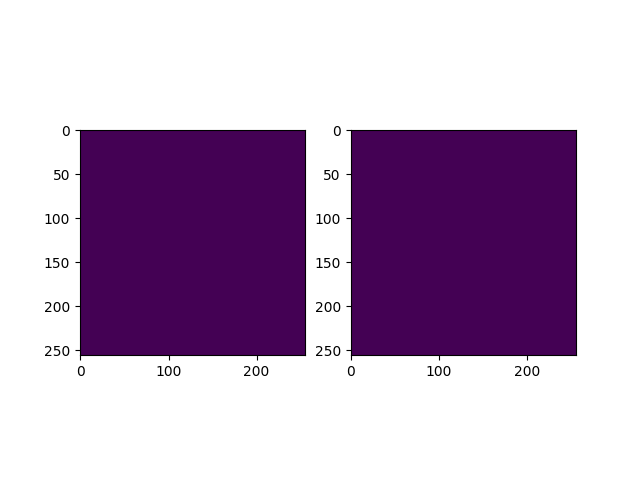

In [18]:
fig, ax = subplots(1,2)
ax[0].imshow(d_grid[2,0,0,:,:,0])
ax[1].imshow(d_grid[2,0,0,:,:,1])

In [19]:
def image_fft(g, scale='none'):
    '''
    Do the complex-to-complex imaging FFT with the correct shifts and correct inverse thingy
    If g.shape = (Npix, Npix) then we assume the center of the UV plane is at
    Npix/2, Npix/2 = DC
    Noramlised by np.prod(img.shape) - which I think is the same as the Xilinx FFT
    
    :scale: 'none' or None for raw FFT output. 'prod' for np.prod(g.shape)

    '''
    # The old version was incorrect!
    #cimg = np.fft.fftshift(np.fft.ifft2(g)).astype(np.complex64)

    if scale == 'none':
        s = 1.0
    elif scale == 'prod':
        s = np.prod(g.shape)
    
    cimg = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(g)))/s
    return cimg


def dofft(grid):
    ndm, nchunk, npix, _, _ = grid.shape
    images = np.zeros((ndm, nchunk, npix, npix, 2), dtype=np.float32)
    for dm in range(ndm):
        for chunk in range(nchunk):
            g = np.zeros((npix, npix), dtype=np.complex64)
            g.real = grid[dm, chunk, :, :, 0]
            g.imag = grid[dm, chunk, :, :, 1]
            img = image_fft(g, scale='prod')
            images[dm, chunk, :, :, 0] = img.real
            images[dm, chunk, :, :, 1] = img.imag         
    
    return images

In [20]:
images = dofft(d_grid[0,...])

<IPython.core.display.Javascript object>


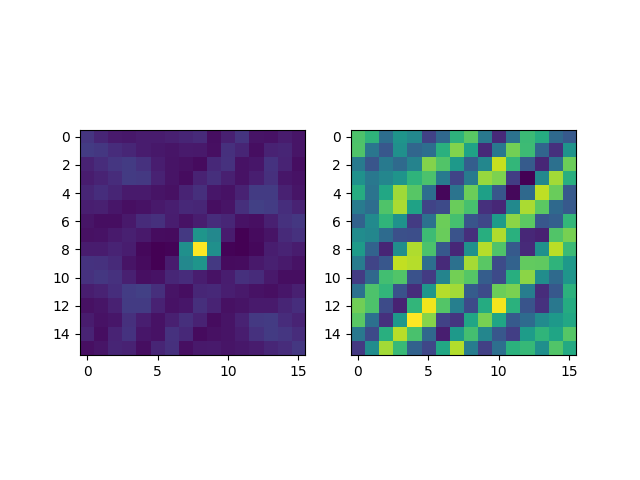

5.2148438
[5.2148438  0.02208408]
real max/min/mean/rms/sum/S/N = 5.21e+00/-4.88e-01/8.90e-02/5.37e-01/2.28e+01/9.7 peak at (8, 8)
imag max/min/mean/rms/sum/S/N = 2.21e-02/-2.21e-02/-1.65e-04/1.07e-02/-4.23e-02/2.1 peak at (13, 4)


In [21]:
fig,ax = subplots(1,2)
islice = slice(128-8, 128+8)
ax[0].imshow(images[0,0,islice,islice,0])
ax[1].imshow(images[0,0,islice,islice,1])

print(images.max())
print(images[0,0,islice,islice,:].max(axis=0).max(axis=0))
print(printstats(images[0,0,islice,islice,0],'real'))
print(printstats(images[0,0,islice,islice,1], 'imag'))

In [22]:
from craft.craco_kernels import FdmtGridder, Imager


In [23]:
gridder = FdmtGridder(None, plan, values)

In [24]:
print(mainbuf.shape)
s = mainbuf.shape
expectshape = (plan.nuvrest, plan.ndout,plan.nt,  plan.nuvwide)
din = np.zeros(expectshape, dtype=np.complex64)
print(din.shape)
#mainbuf has extra uvs in them that we wnt to remove
din.real = mainbuf[:plan.nuvrest,:,0,:,:,0]               
din.imag = mainbuf[:plan.nuvrest,:,0,:,:,1]                              
din = din.transpose([0,2,1,3])
print(din.shape)
print(expectshape)
grid = gridder(0, 0, din)

(664, 186, 11, 256, 8, 2)
(659, 186, 256, 8)
(659, 256, 186, 8)
(659, 186, 256, 8)


In [25]:
print(grid.shape)

(256, 256)


In [26]:
imgr = Imager(None, plan, values)

In [27]:
img = imgr(grid)

<IPython.core.display.Javascript object>


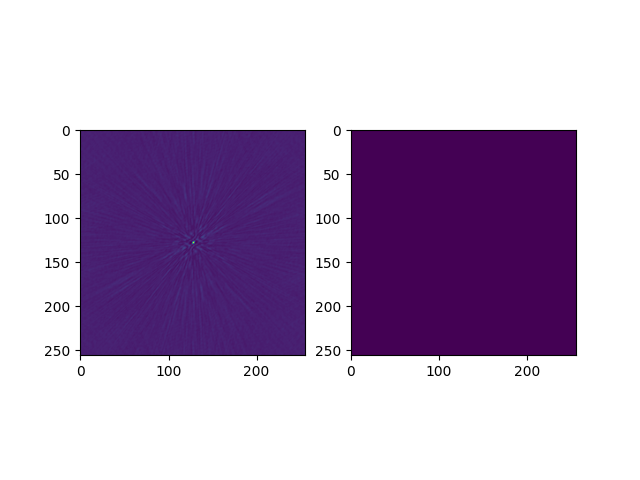

0.0


In [28]:
fig, ax = subplots(1,2)
ax[0].imshow(img.real)
ax[1].imshow(img.imag)
print(img.imag.max())

<IPython.core.display.Javascript object>


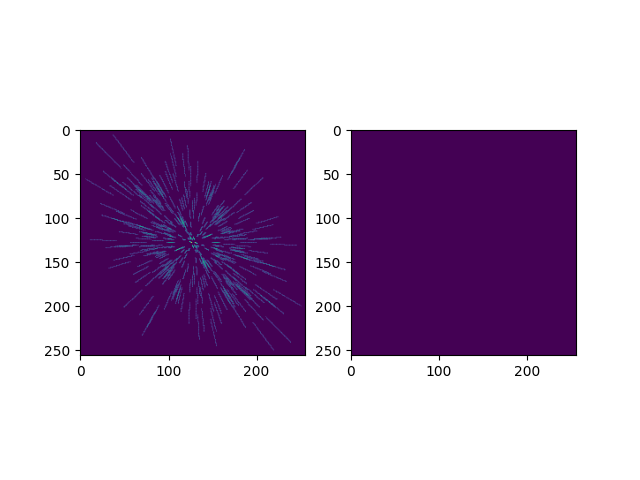

0.0


In [29]:
fig, ax = subplots(1,2)
ax[0].imshow(grid.real)
ax[1].imshow(grid.imag)
print(img.imag.max())

In [30]:
print(d_grid.shape)

(4, 2, 32, 256, 256, 2)


<IPython.core.display.Javascript object>


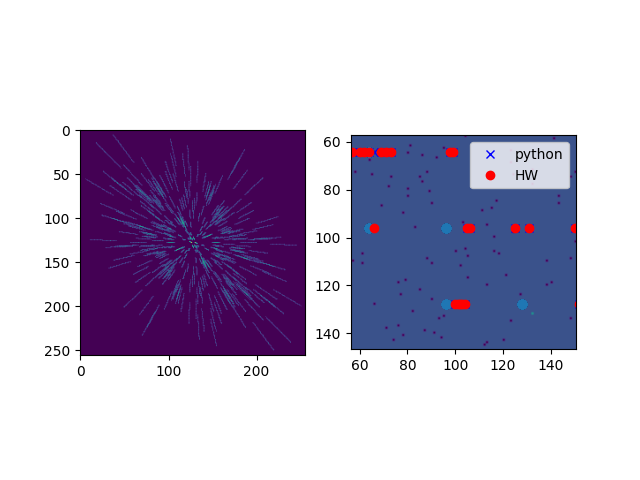

0


In [31]:
d = d_grid[0,0,0,:,:,:]
fig, ax = subplots(1,2)
ax[0].imshow(d[:,:,0])
ax[1].imshow(d[:,:,1])
print(d[:,:,1].max())


<IPython.core.display.Javascript object>


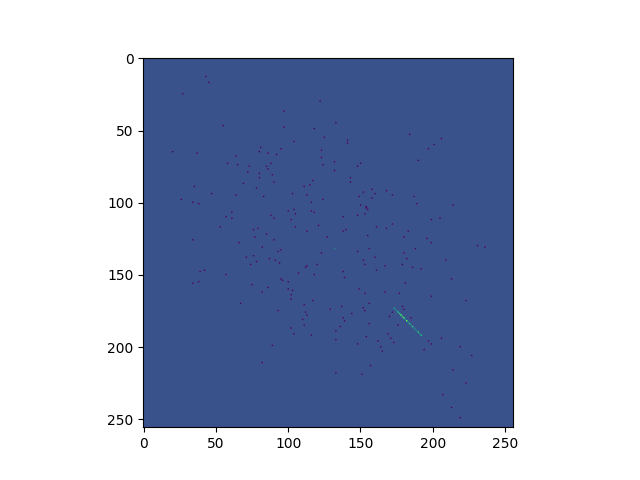

In [45]:
diff = grid.real - d[:,:,0]
figure()
imshow(diff)

<IPython.core.display.Javascript object>


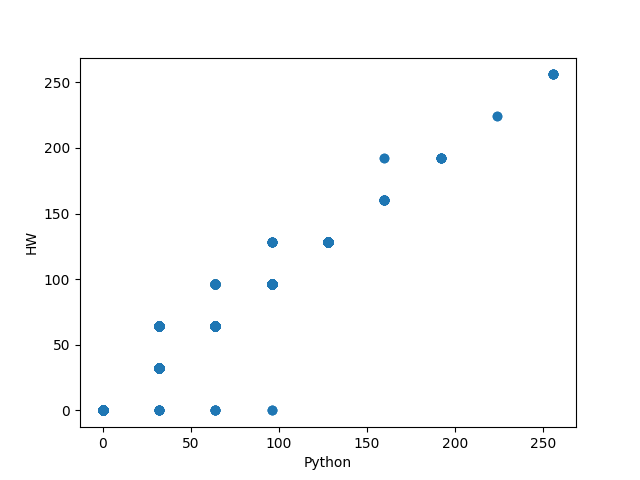

Text(0, 0.5, 'HW')

In [46]:

figure()
scatter(grid.real, d[:,:,0])
xlabel('Python')
ylabel('HW')

<IPython.core.display.Javascript object>


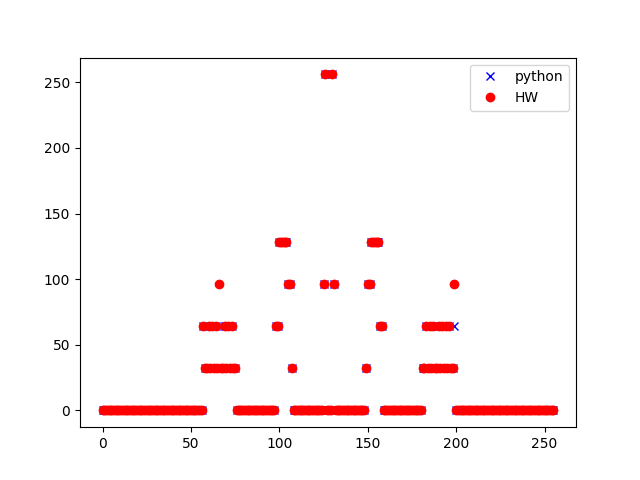

In [43]:
figure()
plot(grid.real[128, :], 'bx', label='python')
plot(d[128,:,0], 'ro', label='HW')
legend()


<IPython.core.display.Javascript object>


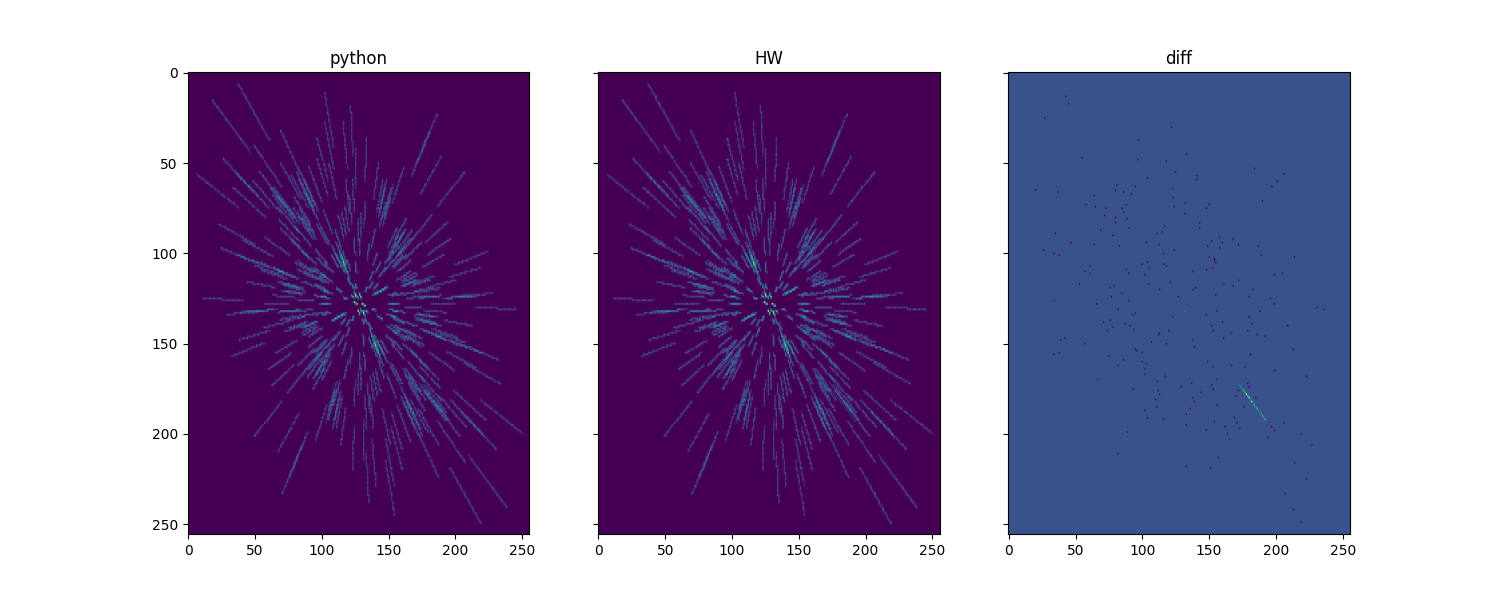

0


In [42]:
fig, ax = subplots(1,3, sharex=True, sharey=True)
kwargs = {'aspect':'auto'} #, 'origin':'lower'}
ax[0].imshow(grid.real, **kwargs)
ax[1].imshow(d[:,:,0], **kwargs)
ax[2].imshow(diff, **kwargs)
ax[0].set_title('python')
ax[1].set_title('HW')
ax[2].set_title('diff')

print(d[:,:,1].max())
fig.set_size_inches([15,6])
#ax[0].set_xlim(128-8,128+8)
#ax[1].set_ylim(128-8,128+8)

# these UV planes are *completely* differet - this is a MASSIVE bug somewhere.... Python gives a believable result
# in the sense that the imaginary part of the image is 0, and the UV plane is symmetric about the diagonal. 
# But what the hell is different? And where is the bug?
# So something requires correction in the HLS code.
# 1. HW is no-diagonal
# 2.  Bottom left of HW looks liek it has 2 parallel UV tracks - so the reflection of the baseline didn't work,
# and maybe I  didn't transpose the  coordintes

In [41]:
histogram(diff)

(array([  224,     0, 65291,     0,     0,    11,     0,     7,     0,
            3]),
 array([-32. , -19.2,  -6.4,   6.4,  19.2,  32. ,  44.8,  57.6,  70.4,
         83.2,  96. ], dtype=float32))

# for 3 antenna version the problem is clear. 
- Theare are 6 baselines as expected in HW and python
- The 3 on the top-left triangle agree
- It looks like the HW conjugation is is incorrect or soemthing like it. But it's really, really wrong.
- Handling of the transposes in the fraco_plan was inconsistent. It was fixed but htere's still some low-level errors.


In [37]:
dir(plan)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'baseline_order',
 'baseline_shape',
 'baselines',
 'boxcar_weight',
 'ddreader_config',
 'ddreader_lut',
 'dmax',
 'dms',
 'dtype',
 'fdmt_plan',
 'fdmt_scale',
 'fft_scale',
 'fft_ssr',
 'fmax',
 'fmin',
 'foff',
 'freqs',
 'get_uv',
 'lower_idxs',
 'lower_instructions',
 'lower_shifts',
 'nbl',
 'nbox',
 'nchunk_time',
 'ncin',
 'ncu',
 'nd',
 'ndout',
 'nf',
 'ngridreg',
 'npix',
 'nt',
 'nuvmax',
 'nuvrest',
 'nuvrest_max',
 'nuvwide',
 'save_fdmt_plan_lut',
 'save_grid_instructions',
 'save_lut',
 'save_pad_lut',
 'threshold',
 'upper_idxs',
 'upper_instructions',
 'upper_shifts',
 'uv_shape',
 'uvcells',
 'values']

In [38]:
!ls -lrth

total 11G
-rw-rw-r-- 1 ban115 ban115  57K Dec 13 13:32 'Check FDMT.ipynb'
-rw-rw-r-- 1 ban115 ban115  11K Feb 21 19:14  cand2.txt
-rw-rw-r-- 1 ban115 ban115   40 Feb 21 19:15  cand3.txt
-rw-rw-r-- 1 ban115 ban115 165M Feb 22 09:18  uv_data_iblk0.npy
-rw-rw-r-- 1 ban115 ban115  192 Feb 22 09:18  candidates_iblk0.npy
-rw-rw-r-- 1 ban115 ban115 1.3G Feb 22 09:18  mainbuf_after_run_iblk0_ib0.npy
-rw-rw-r-- 1 ban115 ban115 1.3G Feb 22 09:18  mainbuf_after_run_iblk0_ib1.npy
-rw-rw-r-- 1 ban115 ban115 1.3G Feb 22 09:18  mainbuf_after_run_iblk0_ib2.npy
-rw-rw-r-- 1 ban115 ban115 1.3G Feb 22 09:18  mainbuf_after_run_iblk0_ib3.npy
-rw-rw-r-- 1 ban115 ban115 1.3G Feb 22 09:18  mainbuf_after_run_iblk0_ib4.npy
-rw-rw-r-- 1 ban115 ban115 1.3G Feb 22 09:18  mainbuf_after_run_iblk0_ib5.npy
-rw-rw-r-- 1 ban115 ban115 1.3G Feb 22 09:18  mainbuf_after_run_iblk0_ib6.npy
-rw-rw-r-- 1 ban115 ban115 1.3G Feb 22 09:18  mainbuf_after_run_iblk0_ib7.npy
-rw-rw-r-- 1 ban115 ban115 257M Feb 22 09:18  fdmt_hist_buf

In [39]:
!cat uv_data.uvgrid.txt

# ant1, ant2, u(pix), v(pix), chan1, chan2
13 16 37 6 252 255
13 16 37 7 251 251
13 16 38 7 244 250
13 16 38 8 240 243
13 16 39 8 236 239
13 16 39 9 229 235
13 16 40 9 228 228
13 16 40 10 220 227
13 16 40 11 218 219
13 16 41 11 212 217
13 15 102 11 249 255
13 16 41 12 208 211
13 16 42 12 203 207
13 15 102 12 241 248
13 16 42 13 197 202
13 16 43 13 195 196
13 15 102 13 232 240
13 16 43 14 187 194
13 15 102 14 228 231
13 15 103 14 224 227
13 17 18 15 251 255
13 16 43 15 186 186
13 16 44 15 179 185
13 15 103 15 215 223
13 17 18 16 248 250
13 17 19 16 242 247
13 16 44 16 175 178
13 16 45 16 171 174
13 15 103 16 207 214
13 17 19 17 239 241
13 17 20 17 234 238
13 16 45 17 164 170
13 16 46 17 163 163
13 15 103 17 199 206
13 17 20 18 230 233
13 17 21 18 225 229
13 16 46 18 155 162
13 15 103 18 190 198
16 20 135 238 253 255
13 17 21 19 221 224
13 17 22 19 216 220
13 16 46 19 153 154
13 16 47 19 147 152
13 15 104 19 182 189
16 20 135 237 244 252
13 17 22 20 212 215
13 17 23 20 207 211
13 16 47 2

In [40]:
for c in plan.uvcells:
    print(c.is_upper, c.uvpix, c.uvpix_upper, c.uvpix_lower)

True (37, 6) (37, 6) (219, 250)
True (37, 7) (37, 7) (219, 249)
True (38, 7) (38, 7) (218, 249)
True (38, 8) (38, 8) (218, 248)
True (39, 8) (39, 8) (217, 248)
True (39, 9) (39, 9) (217, 247)
True (40, 9) (40, 9) (216, 247)
True (40, 10) (40, 10) (216, 246)
True (40, 11) (40, 11) (216, 245)
True (41, 11) (41, 11) (215, 245)
True (102, 11) (102, 11) (154, 245)
True (41, 12) (41, 12) (215, 244)
True (42, 12) (42, 12) (214, 244)
True (102, 12) (102, 12) (154, 244)
True (42, 13) (42, 13) (214, 243)
True (43, 13) (43, 13) (213, 243)
True (102, 13) (102, 13) (154, 243)
True (43, 14) (43, 14) (213, 242)
True (102, 14) (102, 14) (154, 242)
True (103, 14) (103, 14) (153, 242)
True (18, 15) (18, 15) (238, 241)
True (43, 15) (43, 15) (213, 241)
True (44, 15) (44, 15) (212, 241)
True (103, 15) (103, 15) (153, 241)
True (18, 16) (18, 16) (238, 240)
True (19, 16) (19, 16) (237, 240)
True (44, 16) (44, 16) (212, 240)
True (45, 16) (45, 16) (211, 240)
True (103, 16) (103, 16) (153, 240)
True (19, 17) 

True (97, 40) (97, 40) (159, 216)
True (98, 40) (98, 40) (158, 216)
False (151, 216) (105, 40) (151, 216)
True (108, 40) (108, 40) (148, 216)
True (117, 40) (117, 40) (139, 216)
False (133, 216) (123, 40) (133, 216)
True (133, 40) (133, 40) (123, 216)
True (176, 40) (176, 40) (80, 216)
False (80, 216) (176, 40) (80, 216)
False (79, 216) (177, 40) (79, 216)
True (43, 41) (43, 41) (213, 215)
True (44, 41) (44, 41) (212, 215)
True (49, 41) (49, 41) (207, 215)
True (50, 41) (50, 41) (206, 215)
True (74, 41) (74, 41) (182, 215)
True (75, 41) (75, 41) (181, 215)
True (98, 41) (98, 41) (158, 215)
False (151, 215) (105, 41) (151, 215)
False (150, 215) (106, 41) (150, 215)
True (108, 41) (108, 41) (148, 215)
True (109, 41) (109, 41) (147, 215)
True (117, 41) (117, 41) (139, 215)
False (133, 215) (123, 41) (133, 215)
True (133, 41) (133, 41) (123, 215)
True (175, 41) (175, 41) (81, 215)
True (176, 41) (176, 41) (80, 215)
False (80, 215) (176, 41) (80, 215)
True (44, 42) (44, 42) (212, 214)
True 

False (103, 193) (153, 63) (103, 193)
True (156, 63) (156, 63) (100, 193)
True (157, 63) (157, 63) (99, 193)
True (176, 63) (176, 63) (80, 193)
True (177, 63) (177, 63) (79, 193)
False (59, 193) (197, 63) (59, 193)
False (58, 193) (198, 63) (58, 193)
True (64, 64) (64, 64) (192, 192)
True (65, 64) (65, 64) (191, 192)
False (177, 192) (79, 64) (177, 192)
False (176, 192) (80, 64) (176, 192)
True (82, 64) (82, 64) (174, 192)
True (85, 64) (85, 64) (171, 192)
True (86, 64) (86, 64) (170, 192)
True (86, 64) (86, 64) (170, 192)
True (87, 64) (87, 64) (169, 192)
True (89, 64) (89, 64) (167, 192)
True (89, 64) (89, 64) (167, 192)
True (90, 64) (90, 64) (166, 192)
True (96, 64) (96, 64) (160, 192)
True (103, 64) (103, 64) (153, 192)
True (109, 64) (109, 64) (147, 192)
True (118, 64) (118, 64) (138, 192)
False (133, 192) (123, 64) (133, 192)
True (125, 64) (125, 64) (131, 192)
False (117, 192) (139, 64) (117, 192)
False (116, 192) (140, 64) (116, 192)
True (144, 64) (144, 64) (112, 192)
True (1

True (99, 85) (99, 85) (157, 171)
True (105, 85) (105, 85) (151, 171)
True (106, 85) (106, 85) (150, 171)
False (142, 171) (114, 85) (142, 171)
True (117, 85) (117, 85) (139, 171)
True (119, 85) (119, 85) (137, 171)
False (129, 171) (127, 85) (129, 171)
False (127, 171) (129, 85) (127, 171)
False (125, 171) (131, 85) (125, 171)
False (113, 171) (143, 85) (113, 171)
True (145, 85) (145, 85) (111, 171)
False (97, 171) (159, 85) (97, 171)
False (96, 171) (160, 85) (96, 171)
True (175, 85) (175, 85) (81, 171)
True (176, 85) (176, 85) (80, 171)
False (66, 171) (190, 85) (66, 171)
False (65, 171) (191, 85) (65, 171)
False (169, 170) (87, 86) (169, 170)
False (168, 170) (88, 86) (168, 170)
False (167, 170) (89, 86) (167, 170)
False (166, 170) (90, 86) (166, 170)
False (165, 170) (91, 86) (165, 170)
False (164, 170) (92, 86) (164, 170)
True (97, 86) (97, 86) (159, 170)
True (98, 86) (98, 86) (158, 170)
True (99, 86) (99, 86) (157, 170)
True (100, 86) (100, 86) (156, 170)
True (106, 86) (106, 8

False (97, 148) (159, 108) (97, 148)
False (96, 148) (160, 108) (96, 148)
False (95, 148) (161, 108) (95, 148)
False (81, 148) (175, 108) (81, 148)
True (217, 108) (217, 108) (39, 148)
True (218, 108) (218, 108) (38, 148)
False (140, 147) (116, 109) (140, 147)
True (117, 109) (117, 109) (139, 147)
False (138, 147) (118, 109) (138, 147)
True (118, 109) (118, 109) (138, 147)
True (121, 109) (121, 109) (135, 147)
False (131, 147) (125, 109) (131, 147)
True (141, 109) (141, 109) (115, 147)
False (110, 147) (146, 109) (110, 147)
False (109, 147) (147, 109) (109, 147)
False (109, 147) (147, 109) (109, 147)
False (108, 147) (148, 109) (108, 147)
False (99, 147) (157, 109) (99, 147)
False (98, 147) (158, 109) (98, 147)
False (97, 147) (159, 109) (97, 147)
True (212, 109) (212, 109) (44, 147)
True (213, 109) (213, 109) (43, 147)
True (214, 109) (214, 109) (42, 147)
True (215, 109) (215, 109) (41, 147)
True (216, 109) (216, 109) (40, 147)
False (140, 146) (116, 110) (140, 146)
False (139, 146) (

True (152, 128) (152, 128) (104, 128)
True (152, 128) (152, 128) (104, 128)
True (153, 128) (153, 128) (103, 128)
True (153, 128) (153, 128) (103, 128)
True (154, 128) (154, 128) (102, 128)
True (154, 128) (154, 128) (102, 128)
True (155, 128) (155, 128) (101, 128)
True (155, 128) (155, 128) (101, 128)
True (156, 128) (156, 128) (100, 128)
True (156, 128) (156, 128) (100, 128)
True (157, 128) (157, 128) (99, 128)
True (158, 128) (158, 128) (98, 128)
True (181, 128) (181, 128) (75, 128)
True (182, 128) (182, 128) (74, 128)
True (183, 128) (183, 128) (73, 128)
True (184, 128) (184, 128) (72, 128)
True (185, 128) (185, 128) (71, 128)
True (186, 128) (186, 128) (70, 128)
True (187, 128) (187, 128) (69, 128)
True (188, 128) (188, 128) (68, 128)
True (189, 128) (189, 128) (67, 128)
True (190, 128) (190, 128) (66, 128)
True (191, 128) (191, 128) (65, 128)
True (192, 128) (192, 128) (64, 128)
True (193, 128) (193, 128) (63, 128)
True (194, 128) (194, 128) (62, 128)
True (195, 128) (195, 128) (

True (159, 153) (159, 153) (97, 103)
True (160, 153) (160, 153) (96, 103)
False (92, 103) (164, 153) (92, 103)
False (91, 103) (165, 153) (91, 103)
False (90, 103) (166, 153) (90, 103)
True (211, 153) (211, 153) (45, 103)
False (45, 103) (211, 153) (45, 103)
True (212, 153) (212, 153) (44, 103)
False (44, 103) (212, 153) (44, 103)
True (213, 153) (213, 153) (43, 103)
False (43, 103) (213, 153) (43, 103)
True (214, 153) (214, 153) (42, 103)
False (42, 103) (214, 153) (42, 103)
False (100, 102) (156, 154) (100, 102)
False (99, 102) (157, 154) (99, 102)
False (90, 102) (166, 154) (90, 102)
False (90, 102) (166, 154) (90, 102)
False (89, 102) (167, 154) (89, 102)
False (89, 102) (167, 154) (89, 102)
True (193, 154) (193, 154) (63, 102)
True (214, 154) (214, 154) (42, 102)
False (42, 102) (214, 154) (42, 102)
True (215, 154) (215, 154) (41, 102)
False (41, 102) (215, 154) (41, 102)
True (216, 154) (216, 154) (40, 102)
False (40, 102) (216, 154) (40, 102)
True (217, 154) (217, 154) (39, 102)

False (30, 87) (226, 169) (30, 87)
False (29, 87) (227, 169) (29, 87)
False (81, 86) (175, 170) (81, 86)
False (81, 86) (175, 170) (81, 86)
False (80, 86) (176, 170) (80, 86)
False (80, 86) (176, 170) (80, 86)
False (79, 86) (177, 170) (79, 86)
False (74, 86) (182, 170) (74, 86)
False (73, 86) (183, 170) (73, 86)
True (187, 170) (187, 170) (69, 86)
False (29, 86) (227, 170) (29, 86)
False (28, 86) (228, 170) (28, 86)
False (27, 86) (229, 170) (27, 86)
False (80, 85) (176, 171) (80, 85)
False (79, 85) (177, 171) (79, 85)
False (78, 85) (178, 171) (78, 85)
False (73, 85) (183, 171) (73, 85)
False (72, 85) (184, 171) (72, 85)
False (27, 85) (229, 171) (27, 85)
False (26, 85) (230, 171) (26, 85)
False (25, 85) (231, 171) (25, 85)
False (24, 85) (232, 171) (24, 85)
False (83, 84) (173, 172) (83, 84)
False (78, 84) (178, 172) (78, 84)
False (77, 84) (179, 172) (77, 84)
False (72, 84) (184, 172) (72, 84)
False (71, 84) (185, 172) (71, 84)
False (70, 84) (186, 172) (70, 84)
False (24, 84) (232